## xcube Data Store Framework - Sentinel Hub

*Please checkout the general introduction to xcube data stores in the Jupyter Notebook [Getting Started](./1_getting_started.ipynb) before jumping into this notebook :)* 

This notebook provides a walk-through demonstrating how to use xcube and the xcube Sentinel Hub (SH) plugin to read and explore data from the [Sentinel Hub cloud API](https://www.sentinel-hub.com/).

In order to run this notebook you need to install the `xcube_sh` plugin. You may do so by executing the following line in your terminal: 

```
$  conda install -c conda-forge xcube-sh
```

Or you can install the `xcube_sh` plugin from sources by following the instructions on https://github.com/dcs4cop/xcube-sh.

**Please note:**
In order to access data from Sentinel Hub, you need Sentinel Hub API credentials. They may be passed as store parameters (see further below) or exported from environment variables.  
In case you have not exported them already, you _may_ also set them by uncommenting the cell below and adjusting the content to your access credentials. However, we do not recommend this method!

In [ ]:
# import os
# os.environ["SH_CLIENT_ID"] =  your_sh_client_id
# os.environ["SH_CLIENT_SECRET"] = your_sh_client_secret

In [2]:
# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

Check wheather the `sentinelhub` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for the `sentinelhub` store? 

In [5]:
get_data_store_params_schema('sentinelhub')

Please note the `client_id` and `client_secret` parameters mentioned at the beginning.

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('sentinelhub', num_retries=400)
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>

Get more info about a specific dataset. This includes a description of the possible open formats:

In [8]:
store.describe_data('S2L2A')

Which parameters must be passsed or are available to open the dataset? 

In [9]:
store.get_open_data_params_schema('S2L2A')

There are 3 required parameters, so we need to provide them to open a dataset, one of them being bbox. Let's set a region covering Hamburg:

In [10]:
bbox=[9.7, 53.4, 10.2, 53.7]

Take a look at the bbox in order to make sure the area is correctly set: 

In [11]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Now set the other parameters for opening the dataset from the store: 

In [12]:
dataset = store.open_data('S2L2A', 
                          variable_names=['B04'], 
                          bbox=bbox, 
                          spatial_res=0.00018, 
                          time_range=('2020-08-10','2020-08-20'), 
                          time_period='1D')
                          # tile_size= [1024,1024])
dataset

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2325, lon: 3873, time: 11)
Coordinates:
  * lat        (lat) float64 53.82 53.82 53.82 53.82 ... 53.4 53.4 53.4 53.4
  * lon        (lon) float64 9.7 9.7 9.7 9.701 9.701 ... 10.4 10.4 10.4 10.4
  * time       (time) datetime64[ns] 2020-08-10T12:00:00 ... 2020-08-20T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(11, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 775, 1291), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2020-11-25T15:42:58.892614
    processing_level:          L2A
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-21T00:00:00+00:00
    time_coverage_duration:    P11DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        53.4
    geospatial_lon_max:        10.39714
    geospatial_lat_max:        53.8185

For further information, a description about the dataset and the bands may be found here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/ .

Plot one time stamp of the dataset for our requested variable: 

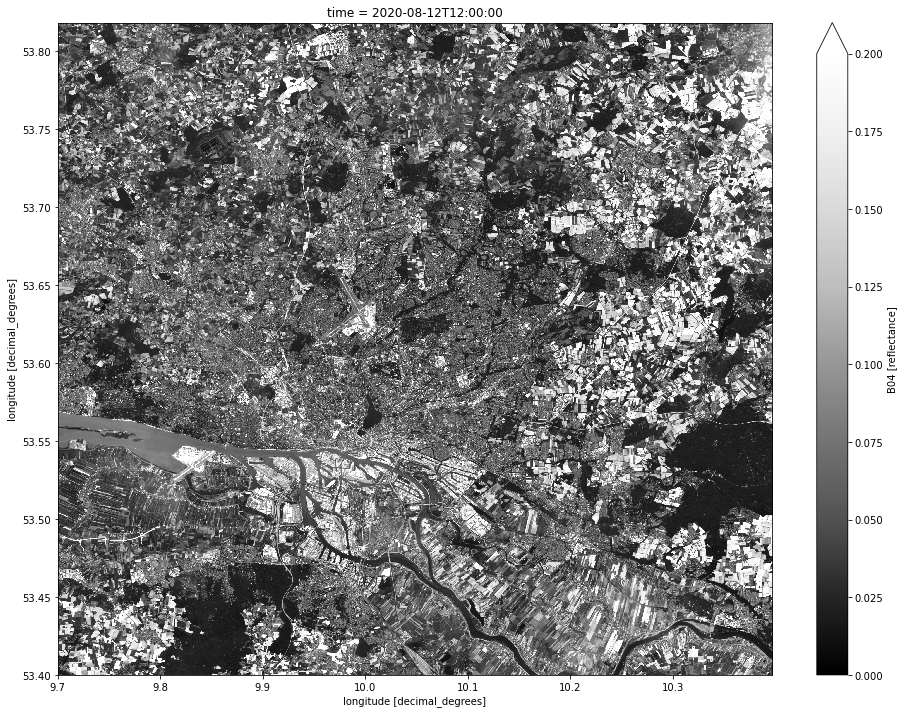

In [13]:
dataset.B04.isel(time=2).plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r')

In case you wonder why we chose Hamburg - well, it is a lovely city! 